In [122]:
import uproot as ur
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak


## Get data, transform ROOT tree into array

In [123]:
# Parameters 
energy = 1 # Energy in GeV. Available energies are 1, 2, 5, 10, 20, 50 GeV.
particle = 'pi+' # Particle incident on detectors



files = [] # List to contain all the data file names

# Loop through some large number to obtain all the available files so we don't have to look them up manually. 
for file_number in range(1, 101):
    try:
        file_name = 'root://sci-xrootd.jlab.org//osgpool/eic/ATHENA/RECO/SINGLE/{particle}\
/{energy}GeV/3to50deg/{particle}_{energy}GeV_3to50deg.{file_number:04d}.root:events'.format(energy = energy, particle = particle, file_number = file_number)
        ur.open(file_name) # Open each file. If the file doesn't exist, it will be skipped and not be added to files list.
        files.append(file_name)
    except:
        continue
        
print("Number of files: {NumFiles}.".format(NumFiles = len(files)))

# Combining all the data files that we found
# Cannot combine each desired branch into one big array. Have to either combine all branches (including ones we don't want like Barrel branches) or make separate arrays for each branch we want.
EcalP_events = ur.concatenate(files, ["EcalEndcapPClusters.edep", "EcalEndcapPClusters.polar.theta"], library = 'np')
HcalHadron_events = ur.concatenate(files, ["HcalHadronEndcapClusters.edep","HcalHadronEndcapClusters.polar.theta"], library = 'np')


Number of files: 10.


In [124]:
def Angle_Energy(detector_events = HcalHadron_events, detector_name = "HcalHadronEndcapClusters", desired_angle = 3):
    num_events = len(detector_events["{detector}.polar.theta".format(detector = detector_name)])
    energies = []
    for i in range(num_events):
        num_hits = len((detector_events["{detector}.polar.theta".format(detector = detector_name)][i]))
        hit_energy = []
        for j in range(num_hits):
            angle = (detector_events["{detector}.polar.theta".format(detector = detector_name)][i][j])
            if angle >= desired_angle - 1 or angle <= desired_angle + 1:
                hit_energy.append(detector_events["{detector}.edep".format(detector = detector_name)][i][j])
        energies.append(hit_energy)
    return energies

In [125]:
# Convert angles to degrees
HcalHadron_events["HcalHadronEndcapClusters.polar.theta"] *= 180/np.pi
EcalP_events["EcalEndcapPClusters.polar.theta"] *= 180/np.pi

In [126]:
# If you want a specific angle range, set filter_angle to True and input angle into angle variable. Will select events with angles "angle" +- 1 degree 
filter_angle = False
angle = 3 # Angle in degrees

Hcal_energies = []
Ecal_energies = []
if filter_angle:
    Hcal_energies = Angle_Energy(HcalHadron_events, "HcalHadronEndcapClusters", angle)
    Ecal_energies = Angle_Energy(EcalP_events, "EcalEndcapPClusters", angle)
else:
    Hcal_energies = HcalHadron_events["HcalHadronEndcapClusters.edep"]
    Ecal_energies = EcalP_events["EcalEndcapPClusters.edep"]
    
print(len(Ecal_energies))
print(len(Hcal_energies))

1000040
1000040


In [171]:
# Weighting the hadron endcap energies
w0 = 6.0
weights = np.arange(w0 + 0.1, 8.2, 0.1)

EW = [] # EW will hold the weighted total energies for each weight in "weights"
for i in range(len(weights)):
    EW.append([])

num_events_hcal = len(Hcal_energies)
num_events_ecal = len(Ecal_energies)
if num_events_hcal != num_events_ecal:
    raise ValueError("Ecal and Hcal not equal in events")
num_events = num_events_hcal

for i in range(num_events):
    hcal_edep = np.sum(Hcal_energies[i])
    ecal_edep = np.sum(Ecal_energies[i])
    for j in range(len(weights)):
        EW[j].append(ecal_edep/weights[j]+hcal_edep)

Minimum resolution is 1.358 using weight 8.1.


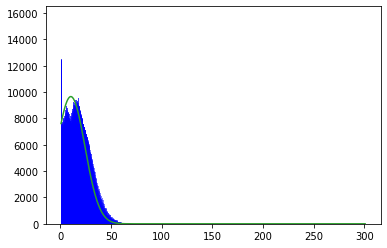

In [178]:
from scipy.stats import norm
from scipy.optimize import curve_fit

def gaussian(x, A, mean, variance):
    return A * np.exp(-((x - mean)**2 / (2. * variance))) # Make sure to take sqrt of variance parameter to get sigma

max_energies = {1:300.5, 2:500.5, 5:500.5, 10:1000.5, 20:1500.5, 50:2000.5}

min_resolution = 999999
min_index = -9999
num_bins = 1000

for i in range(len(EW)):
    hist_data, bins, patches = plt.hist(EW[i], num_bins, (0.5, max_energies[energy]+.5), density=False, facecolor='b', alpha=.5)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    popt, pcov = curve_fit(gaussian, xdata=binscenters, ydata=hist_data)
    resolution = np.sqrt(popt[2])/popt[1]
    if resolution < min_resolution:
        min_resolution = resolution
        min_index = i

        
# Plotting the histogram with the optimal weight
hist_data, bins, patches = plt.hist(EW[min_index], num_bins, (0.5, max_energies[energy]+.5), density=False, facecolor='b', alpha=.5)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
popt, pcov = curve_fit(gaussian, xdata=binscenters, ydata=hist_data)

plt.plot(binscenters, gaussian(binscenters, *popt))

print("Minimum resolution is {res} using weight {weight}.".format(res=round(min_resolution,3), weight=round(weights[min_index],2)))


### Next steps:
### ~1) Filter the angles. Choose a certain angle, then fill arrays of edep for that angle~
### 2) Fill a weighting histogram and fit it with a Gaussian to obtain the optimal weight
### 3) Fill a new histogram with the optimally weighted energy dependence and fit it to obtain the energy resolution
### 4) Do this for each energy and then plot (like EIC_EndCap.C)
